# Bayesian Networks for Estimating Attack Vector

## Intro & motivating example

Humans are notoriously bad at reasoning about probabilities: more often than not, we rely on cognitive shortcuts (heuristics and biases) instead of actually calculating the liklihood of events. This can be a good thing; just think how paralyzed we would be if we stopped to calculate the probability of rain every time we heard raindrops on our window, rather than just grabbing an umbrella! Even computers can start to run into tractability problems when working with probability distributions involving even a few dozen variables. In this tutorial, we will introduce a tool, called Bayesian networks, for automatically and efficiently reasoning about probabilities. These networks will allow us to ask questions like "given this new evidence, what is the probability of some hidden variable being true" or "what is the most likely explanation for some set of observations?". These questions might remind you of our lectures on Hidden Markov Models (HMMs); it turns out that Bayesian networks can be used to represent Markov processes, but they are much more expressive and can be used to model much more complicated scenarios.

- Motivating star wars^tm example from project description
- More detailed list of topics/methods covered and how they relate to the example. i.e. give an outline of the rest of the tutorial.

### References
- \[AIMA\] Chapter 13, 14
- [R. Dechter, "Bucket Elimination: A Unifying Framework for Probabilistic Inference"](https://webdocs.cs.ualberta.ca/~rgreiner/C-366/RG-2002-SLIDES/BucketElim.pdf) 

## Probability Review
- This section won't provide a huge overview of probability, but just a reminder of the relevant parts.
- Random variables and joint probability distributions (for n binary variables, requires 2^n storage)
- Reasoning using joint distributions (13.3)
    - just read out e.g. P(A ^ B)
    - marginalization to get marginal probability e.g. just P(A) = P(A ^ B) + P(A ^ !B) (plus general eq.)
    - Conditional/posterior probabilities, product rule P(A ^ B) = P(A | B)P(B), and conditioning (marginalization but with conditional probs).
    - Derive P(X|e) = P(X^e)/P(e) = aP(X^e) = a \sum_y P(X, e, y) (normalization to get a so that P(X|e)+P(!X|e)=1
    - Remark: this would allow us to answer whatever queries we want to ask just by looking in the joint distribution table. BUT that table has size O(2^n) and requires O(2^n) to process by summing over it.
- Reasoning using conditional distributions (13.4)
    - Lots of redundant information in full joint distribution (like how your toothache affects the weather, ignoring causality)
    - Independence! Conditional independence (based on causality)!
    - Allows factoring the joint distribution into multiple smaller conditional distributions, saving on size. 2^n+2^m << 2^{n+m}    

## Bayesian Networks

Exploiting conditional independence can allow us to reason much more efficiently about joint probabilities, but it would be really nice if we could automate the inference process by encoding conditional probabilities in a convenient data structure. Since dependence relates each variable to a set of "parent" variables, a natural structure is a directed graph, where
- Each node corresponds to an uncertain variable (in this tutorial, we'll restrict ourselves to discrete random variables),
- If variable $B$ is dependent on $A$, then we draw a directed edge from node `A` to node `B` in the graph, and
- Each node $X$ is labelled with its conditional probability distribution $P(X\ |\ \text{Parents}(X))$, which takes the form of a table with a row for each combination of assignments to the parent variables of $X$, specifying the probabilities that $X$ takes on each of its values conditioned on those parent variable assignments.

Since we don't want any variable to depend (directly or indirectly) on itself, this graph must not have any directed cycles (making it a *directed acyclic graph*. An example graph is shown in the figure below. Given this structure, we can see that it directly encodes both independence and conditional independence: sibling nodes (i.e. nodes sharing a parent) are conditionally independent, while nodes in disconnected graphs are independent.

We call this data structure a Bayesian network (or sometimes a *belief network* or *causal network*). These networks can represent any full joint distribution, but depending on the degree to which causal relationships allow us to factor the joint distribution into smaller conditional distributions, Bayesian networks can encode this information much more compactly. In the next example, we'll give a simple example of a Bayesian network and show how we can make inference based on these networks.

### A simple example

As a simple example, we'll use the scenario from Fig. 14.2 in Russel & Norvig. In this scenario, you've just installed a new alarm in your house, and since you don't want Google spying on your home, you've chosen not to connect the alarm to the internet. Instead, you've asked your neighbors, John and Mary, to listen for the alarm and call you if they hear it going off. Complicating matters, the alarm will go off if a burglary occurs, but it is a little too sensitive and will also go off if an earthquake occurs. In addition, John will will sometimes confuse a telephone ringing for the alarm and call then as well, and because Mary likes listening to loud music, she will sometimes miss the alarm altogether.

In this scenario, we essentially have five uncertain boolean variables:
+ `B`: whether a burglary has occurred,
+ `E`: whether an earthquake has occurred,
+ `A`: whether the alarm has gone off,
+ `J`: whether John calls you, and
+ `M`: whether Mary calls you.

Note that only `J` and `M` are observable. If we were to encode the full joint probability distribution, we'd need to store a table of size $O(2^n) = O(32)$. This is not too large in thi scase, but if you have even 30 variables then the joint distribution table would require $O(4$ GB$)$ of storage, and adding a 31st variable would require another 4 GB! We are clearly on the wrong side of this exponential when it comes to the joint distribution.

To make the problem more tractable, we can exploit the causal relationships between these variables, allowing us to store a handful of smaller conditional distributions rather than a monolithic joint distribution. The causal structure of this problem has the structure shown in the image below (reprinted from Russell & Norvig):

<img src="files/figs/alarm-problem-structure.png">

Since `J` and `M` only depend on `A`, we don't need to explicitly store the effect of an earthquake on the probability of John calling. Instead of a 32-entry joint distribution, we only need to store 20 values in 5 smaller conditional distributions. Only 10 entries are shown here because for boolean variables the probability of a false value is fixed at 1-(the probability of a true value). For scenarios with even more variables, these savings would be even more dramatic.

We've written classes in `bayes_net.py` implementing the basic functionality of Bayesian networks for you, allowing you to represent these networks programmatically. You should go check out the source code to get an idea of what features are available, and a basic example of constructing a network for this example scenario is given below.

Have 5 nodes and 4 edges


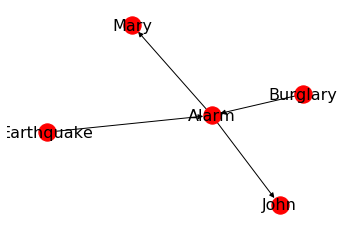

In [5]:
## Example code for constructing the simple burglary example from AIMA (Fig. 14.2)
from bayes_net import BayesNet, BayesNode
import numpy as np

# First, instantiate the two nodes that have no parents in the network.
# The domain of these variables is just {True, False} here, but we support arbitrary discrete domains
burglary_node = BayesNode('Burglary')
burglary_node.set_marginal_distribution({True: 0.001, False: 0.999})
earthquake_node = BayesNode('Earthquake')
earthquake_node.set_marginal_distribution({True: 0.002, False: 0.998})

# Now we can instantiate nodes with probabilities conditioned on their parents
# We have to build the conditional distribution table one entry at a time, for each combination
# of parent variables
alarm_node = BayesNode('Alarm')
alarm_node.add_entry([(burglary_node, True), (earthquake_node, True)], {True: 0.95, False: 0.05})
alarm_node.add_entry([(burglary_node, True), (earthquake_node, False)], {True: 0.94, False: 0.06})
alarm_node.add_entry([(burglary_node, False), (earthquake_node, True)], {True: 0.29, False: 0.71})
alarm_node.add_entry([(burglary_node, False), (earthquake_node, False)], {True: 0.001, False: 0.999})

john_node = BayesNode('John')
john_node.add_entry([(alarm_node, True)], {True: 0.9, False: 0.1})
john_node.add_entry([(alarm_node, False)], {True: 0.05, False: 0.95})

mary_node = BayesNode('Mary')
mary_node.add_entry([(alarm_node, True)], {True: 0.7, False: 0.3})
mary_node.add_entry([(alarm_node, False)], {True: 0.01, False: 0.99})

# Now we can create a BayesNet object to store all the nodes.
net = BayesNet([burglary_node, earthquake_node, alarm_node, john_node, mary_node])

# As a sanity check, we can visualize the network to make sure it matches our model above.
# This visualization is auto-generated, so it will be a bit messy, but we can still see
# the overall structure of the network.
net.draw_net()

- What can they do for you (with reference to the simple example)?
    - Answer queries on the joint probability distribution e.g. P(a, b, !c, d, !e) = \product_i P(x_i | parents(x_i))
    - Query the posterior given evidence e.g. P(X | e) = aP(X, e) = a \sum_{y not x not e} P(X, e, y) <- same as above
    - MAP: max liklihood explanation, the X with the highest probability given e.

## Brute Force Method
- Describe brute-force method for getting probability estimates
    - 14.4.1
    - O(n2^n) for n vars

In [ ]:
def brute_force_query(X, e, net):
    """Returns the posterior probability P(x | e) using the Bayesian network `net`,
    using a brute force enumeration method with time complexity O(n2^n), where
    n is the number of variables in the network.
    
    Inputs:
        X: a list of variable names for which we will calculate posteriors
        e: a list of tuples (name, value) specifying assignments to evidence variables
            (we assume that e and X are disjoint)
    Outputs:
        P: a distribution over the query variables in X (a dict mapping names in
           X to a probability value)
    """
    pass

- benchmark the brute force algorithm to show how exponential it is
    - Simple example from last section
    - Star wars example from this section

In [ ]:
# Run brute_force_query on the two examples to see how long they take

- Simple speedup via DFS enumeration-ask alg from book fig 14.9
    - Explain how it works
    - Still super slow: O(2^n) for n

In [ ]:
# CITE: Russel & Norvig AIMA Ch 14, Section 4, Fig. 14.9
def simple_query(X, e, net):
    """Returns the posterior probability P(x | e) using the Bayesian network `net`,
    using an improved enumeration method with time complexity O(2^n), where n is
    the number of variables in the network, using analogue to depth-first search.
    
    Inputs:
        X: a list of variable names for which we will calculate posteriors
        e: a list of tuples (name, value) specifying assignments to evidence variables
            (we assume that e and X are disjoint)
    Outputs:
        P: a distribution over the query variables in X (a dict mapping names in
           X to a probability value)
    """
    pass

def enumerate_all(variables, e):
    """Computes one step in the depth-first iteration of the Bayesian network"""
    pass

- benchmark the simple algorithm to show how it performs better than the brute force method
    - Simple example from last section
    - Star wars example from this section

In [ ]:
# Run simple_force_query on the two examples to see how long they take

## Bucket Elimination

In [1]:
# This is the main notebook to run.
# In this notebook, we go through the "attack-estimation" portion of the project.
# Some utility code, including base classes, lives in files outside this notebook.

In [2]:
# A bunch of imports
from bayes_net import BayesNet, BayesNode
import numpy as np

0.024000000000000004
Have 4 nodes and 3 edges


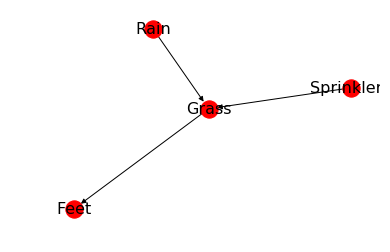

Rain
Sprinklers
Grass
Feet


In [3]:
# A demonstration for developers of how to create a BayesNet. In this example, I define the likelihood of getting
# wet feet as a function of wet grass, which is a function of raining and sprinkling.

# First, declare a bunch of nodes.
rain_node = BayesNode('Rain')
rain_node.set_marginal_distribution({True: 0.2, False: 0.8})
sprinklers_node = BayesNode('Sprinklers')
sprinklers_node.set_marginal_distribution({'on': 0.6, 'off': 0.4})
grass_node = BayesNode('Grass')
grass_node.add_entry([(rain_node, True), (sprinklers_node, 'on')], {'wet': 0.95, 'dry': 0.05})
grass_node.add_entry([(rain_node, True), (sprinklers_node, 'off')], {'wet': 0.6, 'dry': 0.4})
grass_node.add_entry([(rain_node, False), (sprinklers_node, 'on')], {'wet': 0.45, 'dry': 0.55})
grass_node.add_entry([(rain_node, False), (sprinklers_node, 'off')], {'wet': 0.1, 'dry': 0.90})
feet_node = BayesNode('Feet')
feet_node.add_entry([(grass_node, 'wet')], {'dry': 0.1, 'damp': 0.5, 'drenched': 0.4})
feet_node.add_entry([(grass_node, 'dry')], {'dry': 0.7, 'damp': 0.2, 'drenched': 0.1})

# Second, create a BayesNet object that just stores all the nodes.
net = BayesNet([rain_node, sprinklers_node, grass_node, feet_node])

# Third, do whatever you want with this data structure, like ask for the conditional distribution for a variable.
fetched_node = net.get_node('Feet')
assert fetched_node == feet_node  # Just a sanity check
# Calculate some joint probabilities
joint_prob = net.calc_joint([(rain_node, True), (sprinklers_node, 'off'), (feet_node, 'damp'), (grass_node, 'wet')])
print(joint_prob)

# Fourth, visualize it all. Right now, visualization is crude (weird layout) but should be correct (arrows the right way.)
net.draw_net()

# Fifth, show off a fancy new topographical ordering method I just wrote.
ordered_nodes = net.get_topographical_ordering()
for node in ordered_nodes:
    print(node.name)

Approximate Inference:

So far in this notebook, we've stuck with relatively small nets and simple distributions. That means that doing exact inference - calculating analytically exactly what some distribution will look like - is possible. For a lot of problems that we care about, though, exact inference isn't possible. There are lots of reasons this might happen: some distribution is wonky and therefore can't be reasoned about analytically, a net is so complex that doing all the math to marginalize out variables seems impossible, etc.

But we don't have to give up. In the following examples, we'll implement two sorts of approximate inference techniques: rejection sampling and Gibbs sampling.

In [4]:
def matches_evidence(node, value, evidence):
    for evidence_name, evidence_value in evidence:
        if node.name == evidence_name:
            if value == evidence_value:
                return True
            return False
    return True
    
# In this sampling method, we just generate random setups through sampling.
# If we satisfy the evidence, we save the state; if we don't we reject the sample and keep trying.
# After saving lots of states, the hope is that we have enough counts to estimate the frequencies of other variables
# conditioned on the evidence.
def rejection_sampling(X, e, net, num_samples=10000):
    # For each of the variables in X, store a count of how often each value in the domain appears.
    # Intialization to zero counts everywhere.
    var_to_val_to_count = {}
    for x in X:
        var_to_val_to_count[x] = {}
        for val in net.get_node(x).domain:
            var_to_val_to_count[x][val] = 0
    # Now, just generate tons of samples in the net, rejecting if it doesn't match the evidence.
    num_rejects = 0
    for sample_idx in range(num_samples):
        # Get a topographical ordering to start sampling.
        ordered_nodes = net.get_topographical_ordering()
        assignments = {}
        reject_sample = False
        for node in ordered_nodes:
            if node.marginal_distribution:
                sample = node.draw_sample()
                assignments[node] = sample
            else:
                parent_val_assignments = [(parent, assignments.get(parent)) for parent in node.parents]
                sample = node.draw_sample(parent_vals=parent_val_assignments)
                assignments[node] = sample
            # Do the rejection part if the node that was sampled contradicts the evidence
            if not matches_evidence(node, sample, e):
                reject_sample = True
                break
        if reject_sample:
            num_rejects += 1
            continue
        # Matched the evidence, so update the counts of valid variable assignments
        for assigned_node, assigned_val in assignments.items():
            if assigned_node.name in var_to_val_to_count.keys():
                var_to_val_to_count[assigned_node.name][assigned_val] += 1
    # At the end, finally have counts that we can use to compute probabilities.
    for x in X:
        relevant_counts = var_to_val_to_count.get(x)
        total_count = sum([count for count in relevant_counts.values()])
        normalized_distribution = {}
        for value, count in relevant_counts.items():
            normalized_distribution[value] = count / total_count
        print("Distribution for ", x, ":", normalized_distribution)
    print("Num samples used:", num_samples - num_rejects)
    print("Num samples rejected", num_rejects)

In [5]:
# Test the rejection sampling code.
# First, a really simple example.
rejection_sampling(['Feet'], [('Rain', False)], net)
# Now, a harder one, with more evidence and asking about more
rejection_sampling(['Rain', 'Grass'], [('Sprinklers', 'on'), ('Feet', 'drenched')], net)


Distribution for  Feet : {'dry': 0.5102168735113451, 'damp': 0.30036354519242825, 'drenched': 0.18941958129622666}
Num samples used: 7977
Num samples rejected 2023
Distribution for  Rain : {True: 0.2998102466793169, False: 0.7001897533206831}
Distribution for  Grass : {'wet': 0.8285895003162556, 'dry': 0.17141049968374447}
Num samples used: 1581
Num samples rejected 8419


In the previous example, we saw how rejection sampling can get us the distributions we want, but we also see one of the big flaws: we end up rejecting lots of samples. Lets do gibbs sampling instead!

In [35]:
# FIXME: this code is ugly, but I do think it's correct.
def gibbs_sampling(X, e, net, burn_in_period=100, eval_period=5000):
    # For each of the variables in X, store a count of how often each value in the domain appears.
    # Intialization to zero counts everywhere.
    var_to_val_to_count = {}
    for x in X:
        var_to_val_to_count[x] = {}
        for val in net.get_node(x).domain:
            var_to_val_to_count[x][val] = 0
    evidence_names = [evidence[0] for evidence in e]
    # Intialize the net with random assignments.
    assignments = {}
    ordered_nodes = net.get_topographical_ordering()
    for node in ordered_nodes:
        if node.marginal_distribution:
            sample = node.draw_sample()
            assignments[node] = sample
        else:
            parent_val_assignments = [(parent, assignments.get(parent)) for parent in node.parents]
            sample = node.draw_sample(parent_vals=parent_val_assignments)
            assignments[node] = sample
    # Now the burn-in section
    all_nodes = net.nodes
    for trial in range(burn_in_period + eval_period):
        # Choose a random node, as long as it's not evidence.
        node_to_swap = np.random.choice(all_nodes)
        while node_to_swap.name in evidence_names:
            node_to_swap = np.random.choice(all_nodes)
        # Generate the distribution over next possible values of the node, conditioned on parents and children.
        parent_assignments = [(parent, assignments.get(parent)) for parent in node_to_swap.parents]
        next_distribution = {}
        for next_val in node_to_swap.domain:
            prob_given_parents = node_to_swap.get_prob_value(next_val, parent_assignments)
            children = net.get_children(node_to_swap)
            prob_from_children = 1.0
            for child in children:
                childs_parent_assignments = []
                # But overwrite with next_val
                for parent in child.parents:
                    if parent == node_to_swap:
                        childs_parent_assignments.append((node_to_swap, next_val))
                        continue
                    childs_parent_assignments.append((parent, assignments.get(parent)))
                prob_of_child = child.get_prob_value(assignments.get(child), childs_parent_assignments)
                prob_from_children = prob_from_children * prob_of_child
            total_prob = prob_given_parents * prob_from_children
            next_distribution[next_val] = total_prob
        # Normalize the distribution and then sample.
        normalizing_factor = sum(next_distribution.values())
        for entry, val in next_distribution.items():
            next_distribution[entry] = val / normalizing_factor
        values = [entry[0] for entry in sorted(next_distribution.items())]
        probabilities = [entry[1] for entry in sorted(next_distribution.items())]
        sampled = np.random.choice(values, p=probabilities)
        assignments[node_to_swap] = sampled
        # If after burn-in, start saving data
        if trial <= burn_in_period:
            continue
        # Save the data.
        for assigned_node, assigned_val in assignments.items():
            if assigned_node.name in var_to_val_to_count.keys():
                var_to_val_to_count[assigned_node.name][assigned_val] += 1
    # At the end, finally have counts that we can use to compute probabilities.
    for x in X:
        relevant_counts = var_to_val_to_count.get(x)
        total_count = sum([count for count in relevant_counts.values()])
        normalized_distribution = {}
        for value, count in relevant_counts.items():
            normalized_distribution[value] = count / total_count
        print("Distribution for ", x, ":", normalized_distribution)

In [36]:
# Test out Gibbs with the same examples as for rejection sampling
gibbs_sampling(['Feet'], [('Rain', False)], net)
print()
gibbs_sampling(['Rain', 'Grass'], [('Sprinklers', 'on'), ('Feet', 'drenched')], net)

Distribution for  Feet : {'dry': 0.5471094218843768, 'damp': 0.27345469093818764, 'drenched': 0.1794358871774355}

Distribution for  Rain : {True: 0.27825565113022604, False: 0.7217443488697739}
Distribution for  Grass : {'wet': 0.8195639127825565, 'dry': 0.18043608721744347}
